# Convolutional Neural Networks

## Dog Identification App 

---

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  
If a dog is detected in the image, it will provide an estimate of the dog's breed.  
If a human is detected, it will provide an estimate of the dog breed that is most resembling. 

![Sample Dog Output](images/sample_dog_output.png)

### The Road Ahead

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  
We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'dogImages/train'

### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [ ]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


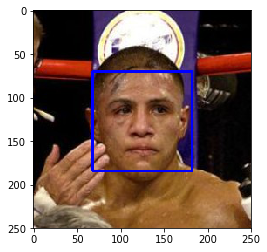

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assess the Human Face Detector

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face. Our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

98% of the faces were detected, and 11% of the dogs were mistakenly detected as humans. This is probaly due to the shape of the dog heads, that might resemble a human face in some perspective.

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

def find_humans(files_short):
    faces = 0
    for file in files_short:
        faces += 1 if face_detector(file) else 0
    return faces

print("Humans: {} humans among {} images".format(find_humans(human_files_short), len(human_files_short)))
print("Dogs  : {} humans among {} images".format(find_humans(dog_files_short), len(dog_files_short)))


Humans: 98 humans among 100 images
Dogs  : 11 humans among 100 images


In reality the images are always a but blurry, distorted, or with bad illumination etc. Plus there are animals that resemble humans as we have seen. 

It is not possible to ask for perfect photos, or if we do it we will loose the goal of a general face recognizer, we may ask for acceptable photos at most, and increase our training dataset and accuracy to improve the overall perfomances.

We should implement image agumentation to make the model more resistant to rotations and illumination modifications, and be able to recognize the real object of the image. 

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In [6]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [7]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [8]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [9]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [10]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__  It seems to have even better results than the human recognition on this 100 images

In [11]:
def find_dogs(files_short):
    faces = 0
    for file in files_short:
        faces += 1 if dog_detector(file) else 0
    return faces

print("Humans: {} dogs among {} images".format(find_dogs(human_files_short), len(human_files_short)))
print("Dogs  : {} dogs among {} images".format(find_dogs(dog_files_short), len(dog_files_short)))

Humans: 2 dogs among 100 images
Dogs  : 100 dogs among 100 images


---
<a id='step3'></a>
## Step 3: CNN to Classify Dog Breeds from Scratch

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">



It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">

Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [12]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:06<00:00, 138.50it/s]


### (IMPLEMENTATION) Model Architecture


![Sample CNN](images/sample_cnn.png)
           
The basic strategy here is to use filters to learn the patterns in the data and then to pass those patterns into an MLP for categorization via softmax.The model consists of the following steps/layers.
Convoluational Portion: This portion of the model takes the image inputs and learns patters while deepening (doubling filters in each sequence) and narrowing (pooling after each set of filters), to produce out best approximation of bottleneck features to pass into an MLP. Relu activation is used at each step.
224 x 224 x 3 inputs (image dimensions plus a layer each for R, G, B)

32 locallly connected filters with kernel 5x5 and stride 1x1
a max pooling layer of size 2 and stride 2
64 locallly connected filters with a bigger kernel 7x7 
a max pooling layer of size 2 ad stride 1.
A Global average pooling 2D layer to flatten the image with dropout probability set at 20%
Here I decided to start the Dense layers, with 500 Nodes in the first layer, with dropout probability 30% and the final layer with 133 nodes (the number of categories)

By tuning the kernel size ad the pool size I saw that the final outcome may vary, so I had to try some combinations. Data agumentation boosted the performances from 9% o 12+%
By adding further convolutional layers it was possible to get even better results, but to speedup the experiments on the kernel sizes I decided to leave the network as it was.

As a final experiment I decided to change the network as it looks now, always stride 2x2 to reduce dimensionality and the number of parameters  but it led to worse performances. 

In [29]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### TODO: Define your architecture.
model.add(Conv2D(filters=32, kernel_size=(5,5), input_shape=(224, 224, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2,2), padding='same'))
model.add(Conv2D(filters=64, kernel_size=(7,7), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1,1), padding='same'))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 220, 220, 32)      2432      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 104, 104, 64)      100416    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 104, 104, 64)      0         
_________________________________________________________________
global_average_pooling2d_4 ( (None, 64)                0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 500)               32500     
__________

### Compile the Model

In [20]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.
Be careful about data augumentation

In [21]:
from keras.preprocessing.image import ImageDataGenerator

# pre-process the data for Keras originally used here
# train_tensors = paths_to_tensor(train_files).astype('float32')/255
# valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
# test_tensors = paths_to_tensor(test_files).astype('float32')/255

train_datagen = ImageDataGenerator(
    rescale=1./ 255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=30,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    'dogImages/train',
    target_size=(224, 224),
    batch_size=20,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    'dogImages/valid',
    target_size=(224, 224),
    batch_size=20,
    class_mode='categorical', shuffle=False)
nb_train_samples = 6680
nb_validation_samples = 835

Found 6680 images belonging to 133 classes.
Found 835 images belonging to 133 classes.


In [22]:
from keras.callbacks import ModelCheckpoint  

epochs = 12
batch_size=20
### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.augment.dr.55.77.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[checkpointer], verbose=1)

Epoch 1/12
334/334 [==============================] - 113s - loss: 4.8848 - acc: 0.0106 - val_loss: 4.8652 - val_acc: 0.0110
Epoch 2/12
334/334 [==============================] - 110s - loss: 4.8656 - acc: 0.0130 - val_loss: 4.8373 - val_acc: 0.0159
Epoch 3/12
334/334 [==============================] - 109s - loss: 4.7943 - acc: 0.0202 - val_loss: 4.7292 - val_acc: 0.0183
Epoch 4/12
334/334 [==============================] - 109s - loss: 4.7299 - acc: 0.0262 - val_loss: 4.6935 - val_acc: 0.0293
Epoch 5/12
334/334 [==============================] - 110s - loss: 4.6755 - acc: 0.0304 - val_loss: 4.7957 - val_acc: 0.0195
Epoch 6/12
334/334 [==============================] - 109s - loss: 4.6370 - acc: 0.0301 - val_loss: 4.6093 - val_acc: 0.0366
Epoch 7/12
334/334 [==============================] - 108s - loss: 4.5971 - acc: 0.0295 - val_loss: 4.5570 - val_acc: 0.0366
Epoch 8/12
334/334 [==============================] - 110s - loss: 4.5536 - acc: 0.0373 - val_loss: 4.4774 - val_acc: 0.0427


### Load the Model with the Best Validation Loss

In [30]:
model.load_weights('saved_models/weights.augment.55.77.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [31]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 12.3206%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [44]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [45]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_6 ( (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 133)               68229     
Total params: 68,229.0
Trainable params: 68,229.0
Non-trainable params: 0.0
_________________________________________________________________


### Compile the Model

In [46]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [47]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.augment.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 1s - loss: 11.5914 - acc: 0.1467 - val_loss: 9.9671 - val_acc: 0.2467
Epoch 2/20
6680/6680 [==============================] - 1s - loss: 9.2624 - acc: 0.3198 - val_loss: 9.3191 - val_acc: 0.3102
Epoch 3/20
6680/6680 [==============================] - 1s - loss: 8.5755 - acc: 0.3865 - val_loss: 8.7649 - val_acc: 0.3701
Epoch 4/20
6680/6680 [==============================] - 1s - loss: 8.2361 - acc: 0.4259 - val_loss: 8.5587 - val_acc: 0.3784
Epoch 5/20
6680/6680 [==============================] - 1s - loss: 8.0761 - acc: 0.4582 - val_loss: 8.5814 - val_acc: 0.3796
Epoch 6/20
6680/6680 [==============================] - 1s - loss: 7.9895 - acc: 0.4741 - val_loss: 8.5011 - val_acc: 0.3820
Epoch 7/20
6680/6680 [==============================] - 1s - loss: 7.8845 - acc: 0.4784 - val_loss: 8.2217 - val_acc: 0.4096
Epoch 8/20
6680/6680 [==============================] - 1s - loss: 7.5823 - a

### Load the Model with the Best Validation Loss

In [48]:
VGG16_model.load_weights('saved_models/weights.augment.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [49]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 48.3254%


### Predict Dog Breed with the Model

In [50]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

In [33]:
import numpy as np

my_ResNet50_bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_ResNet50 = my_ResNet50_bottleneck_features['train']
valid_ResNet50 = my_ResNet50_bottleneck_features['valid']
test_ResNet50 = my_ResNet50_bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

Mainly I decided to stick to ResNet because of the very first experiments I've done. I tried all the networks and with no tuning ResNet gave me the better results. I tried with many combinations of Dnse layers and I found out that by adding nodes usually the accuracy increased, but of course the perfomances dropped. So I decided to leave the first layer with the same amount of nodes as the Global Average pool layer, then halve it and finally get the breed probabilities.

I found out that incremental Dropout gives better results that same dropout at every layer, after some exepriments starting from 0.5 in the last layer and decreasing by 0.1 the dropout probability at each layer, was the most successfull technique.

As optimizers I tried SDG, Adam and Adamax, the latter gave me better results.

The same network without the extra Dense layers dropped 
- from 84.21% of accuracy, sometimes with regularization even 85.01%
- to 80.65%  

but the number of parameters also dropped 
- from 6,430,853
- to 272,517
A tradeoff is probably necessary to lower the number of parameters.

In [41]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras import regularizers

my_ResNet50_model = Sequential()
my_ResNet50_model.add(GlobalAveragePooling2D(input_shape=train_ResNet50.shape[1:]))
my_ResNet50_model.add(Dropout(0.3))
my_ResNet50_model.add(Dense(2048, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
my_ResNet50_model.add(Dropout(0.4))
my_ResNet50_model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
my_ResNet50_model.add(Dropout(0.5))
my_ResNet50_model.add(Dense(133, activation='softmax'))

my_ResNet50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_7 ( (None, 2048)              0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dropout_18 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_19 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 133)               136325    
Total para

### (IMPLEMENTATION) Compile the Model

In [42]:
from keras.optimizers import Adam, Adamax

my_ResNet50_model.compile(loss='categorical_crossentropy', optimizer=Adamax(lr=0.0003), metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [43]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./ 255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=30,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    'dogImages/train',
    target_size=(224, 224),
    batch_size=20,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    'dogImages/valid',
    target_size=(224, 224),
    batch_size=20,
    class_mode='categorical', shuffle=False)
nb_train_samples = 6680
nb_validation_samples = 835

Found 6680 images belonging to 133 classes.
Found 835 images belonging to 133 classes.


In [46]:
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/weights.l2.2048.1024.best_adamax.ResNet50.hdf5', 
                               verbose=1, save_best_only=True)

epochs = 40
batch_size = 64
# ResNet50_model.fit_generator(
#     train_generator,
#     steps_per_epoch=nb_train_samples // batch_size,
#     epochs=epochs,
#     validation_data=validation_generator,
#     validation_steps=nb_validation_samples // batch_size,
#     #workers=12
#     #batch_size=20, 
#     callbacks=[checkpointer], verbose=1)

my_ResNet50_model.fit(train_ResNet50, train_targets, 
          validation_data=(valid_ResNet50, valid_targets),
          epochs=epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=1)


Train on 6680 samples, validate on 835 samples
Epoch 1/40
6680/6680 [==============================] - 1s - loss: 2.1820 - acc: 0.9187 - val_loss: 2.3871 - val_acc: 0.8455
Epoch 2/40
6680/6680 [==============================] - 1s - loss: 2.1550 - acc: 0.9196 - val_loss: 2.3619 - val_acc: 0.8455
Epoch 3/40
6680/6680 [==============================] - 1s - loss: 2.1251 - acc: 0.9168 - val_loss: 2.3359 - val_acc: 0.8491
Epoch 4/40
6680/6680 [==============================] - 1s - loss: 2.0849 - acc: 0.9237 - val_loss: 2.3133 - val_acc: 0.8455
Epoch 5/40
6680/6680 [==============================] - 1s - loss: 2.0573 - acc: 0.9275 - val_loss: 2.2695 - val_acc: 0.8515
Epoch 6/40
6680/6680 [==============================] - 1s - loss: 2.0152 - acc: 0.9313 - val_loss: 2.2551 - val_acc: 0.8467
Epoch 7/40
6680/6680 [==============================] - 2s - loss: 1.9792 - acc: 0.9299 - val_loss: 2.2142 - val_acc: 0.8611
Epoch 8/40
6680/6680 [==============================] - 1s - loss: 1.9540 - ac

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [52]:
my_ResNet50_model.load_weights('saved_models/weights.l2.2048.1024.best_adamax.ResNet50.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [53]:
# get index of predicted dog breed for each image in test set
ResNet50_predictions = [np.argmax(
    my_ResNet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_ResNet50]

# report test accuracy
test_accuracy = 100*np.sum(
    np.array(ResNet50_predictions)==np.argmax(test_targets, axis=1))/len(ResNet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 84.2105%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [49]:
from extract_bottleneck_features import *

def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

def ResNet50_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    predicted_vector = my_ResNet50_model.predict(bottleneck_feature)
    
    # get the three most likely dog breeds for crossbreed recognition
    # we should define a relative threshold, based on the most probabile
    # breed and check if there are other breeds with similar probability
    #     indexes = np.argpartition(predicted_vector, -3)[-3:]
    #     indexes[np.argsort(predicted_vector[indexes])]
    #     return dog_names[indexes]
    # return the most probabile dog breed
    breed = dog_names[np.argmax(predicted_vector)]
    if dog_detector(img_path):
        race = 'Dog'
    else:
        if face_detector(img_path) > 0:
            race = 'Human'
        else:
            race = 'Thing'
    return race, breed


---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [50]:
def breed_discovery(img_path):
    race, breed = ResNet50_breed(img_path)
#     img = cv2.imread(img_path)
#     cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     imgplot = plt.imshow(cv_rgb)
    return "Hi {}, your breed is {}".format(race, breed)


---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ After all this algorithm have a pretty good outcome. 
ResNet50 and VGG19 were the easiest starting points. I tried both and the outome were slightly better with ResNet50, so I decided to pursue my experiments mainly on that model.

### Failure in recognizing
I tried with 50 photos and the only image where no dogs or faces were recognized was my photo..and I can't really see my connection with the Chinese crested :). The same image with higher resolution and no cropping was correclty recognized, altough this frustrating breed still didn't change, only adding regularization changed me to a Maltese.

### Behaviours
I tried some photos with different dog behaviours and I left here the  one that was clearly wrong. Adding more photos with different behaviours per breed can be a good starting point.

### Crossbreeds
Another fun part was putting photos of my little crossbreed dog, and check how many times the outcome was one of the breeds that she is coming from. Depending on the closeness and the angle I often found one of the 4 breeds that she have. But probably this can be a good point to increse the accuracy, training with Multi-Label images with a set of crossbreed dogs and extract not only the argmax but the first N breeds, I wrote a note in the code:

    get the N most likely dog breeds for crossbreed recognition we may define a relative threshold, based on the most probabile breed and check if there are other breeds with similar probability

### Other improvements
I'll need to improve my model first of all by adding Images Agumentation, as I have done in the earlier portion of the notebook. 
I'll try Xception as it promises good results in its paper.
My model is probably too simple and not enogh tuned, I'll try more aggressive Dropout, to prevent overfitting.

To implement Data Augmentation I think the only way is to import the whole network and set as trainable only the last layers. I'll do that in a separate notebook as well as Xception experiment.

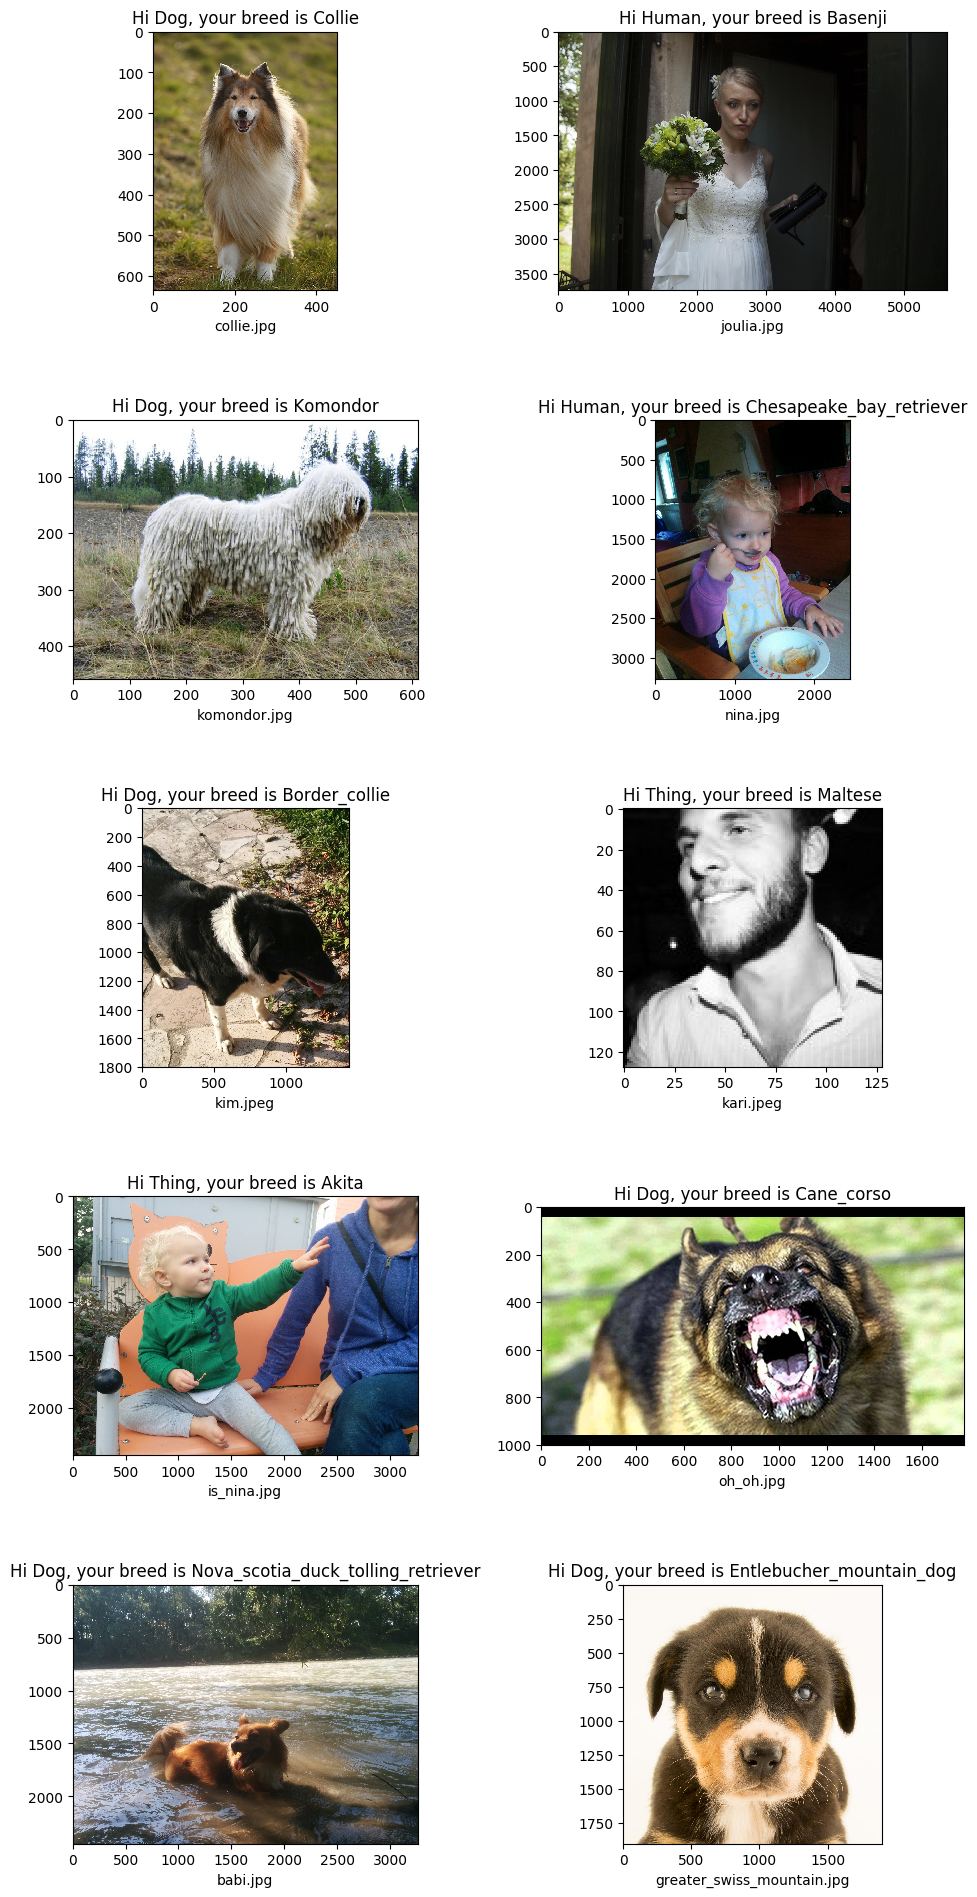

In [51]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
fig = plt.figure(figsize=(12, 24), dpi=100)
files = os.listdir("samples")
cols = 2

plt.subplots_adjust(hspace=0.500)
for i,f in enumerate(files):
    ax = plt.subplot(len(files)/cols,cols,i+1)
    ax.plot(x,y)
    
    img = mpimg.imread("samples/" + f)
    ax.imshow(img)
    ax.set_title(breed_discovery("samples/" + f), fontsize=12)
    ax.set_xlabel(f)
plt.show()